In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bharatr/SP_500_Index_Datas.csv
/kaggle/input/sp500-daily-19862018/spx.csv


In [2]:
df=pd.read_csv('/kaggle/input/bharatr/SP_500_Index_Datas.csv',parse_dates=['date'])
df.head()

,date,close
0,1986-01-02,209.59
1,1986-01-03,210.88
2,1986-01-06,210.65
3,1986-01-07,213.80
4,1986-01-08,207.97


In [3]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8
np.random.seed(1)
tf.random.set_seed(1)

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.1.0


In [4]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=df.date,y=df.close,mode='lines',name='close'))
fig.update_layout(showlegend=True)
fig.show()

In [5]:
train_size=int(len(df)*0.8)
test_size=len(df)-train_size
train,test=df.iloc[0:train_size],df.iloc[train_size:len(df)]
print(train_size,test_size)

6553 1639


In [6]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(train[['close']])

train['close']=scaler.transform(train[['close']])
test['close']=scaler.transform(test[['close']])

In [7]:
def create_sequences(X,y,time_steps=1):
    Xs,Ys=[],[]
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        Ys.append(y.iloc[i+time_steps])
    return np.array(Xs),np.array(Ys)

In [8]:
time_steps=30

X_train,y_train=create_sequences(train[['close']],train.close,time_steps)
X_test,y_test=create_sequences(test[['close']],test.close,time_steps)

In [9]:
print(X_train.shape)

(6523, 30, 1)


In [10]:
timesteps=X_train.shape[1]
num_features=X_train.shape[2]

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

model=Sequential([LSTM(128,input_shape=(timesteps,num_features)),
                  Dropout(0.2),
                  RepeatVector(timesteps),
                  LSTM(128,return_sequences=True),
                  Dropout(0.2),
                  TimeDistributed(Dense(num_features))
                 ])
model.compile(loss='mae',optimizer='adam')
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

In [11]:
es=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,mode='min')
history=model.fit(X_train,y_train,epochs=100,batch_size=32,validation_split=0.1,callbacks=[es],shuffle=False)


Train on 5870 samples, validate on 653 samples
Epoch 1/100
5870/5870 [==============================] - 15s 3ms/sample - loss: 0.1625 - val_loss: 0.1610
Epoch 2/100
5870/5870 [==============================] - 11s 2ms/sample - loss: 0.1114 - val_loss: 0.0986
Epoch 3/100
5870/5870 [==============================] - 11s 2ms/sample - loss: 0.0903 - val_loss: 0.0443
Epoch 4/100
5870/5870 [==============================] - 11s 2ms/sample - loss: 0.0802 - val_loss: 0.0442
Epoch 5/100
5870/5870 [==============================] - 11s 2ms/sample - loss: 0.0717 - val_loss: 0.0639
Epoch 6/100
5870/5870 [==============================] - 11s 2ms/sample - loss: 0.0776 - val_loss: 0.0327
Epoch 7/100
5870/5870 [==============================] - 11s 2ms/sample - loss: 0.0750 - val_loss: 0.0313
Epoch 8/100
5870/5870 [==============================] - 11s 2ms/sample - loss: 0.0744 - val_loss: 0.0580
Epoch 9/100
5870/5870 [==============================] - 11s 2ms/sample - loss: 0.0758 - val_loss: 0.0525

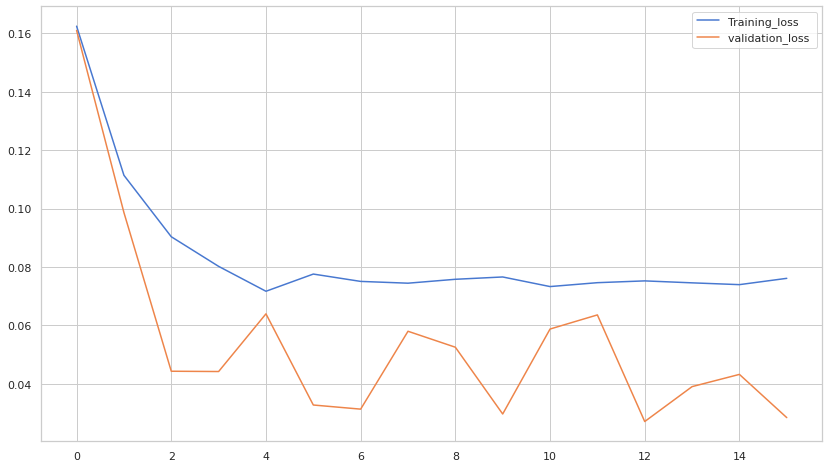

In [12]:
plt.plot(history.history['loss'],label="Training_loss ")
plt.plot(history.history['val_loss'],label="validation_loss ")
plt.legend()

In [13]:
X_train_pred=model.predict(X_train)
train_mae_loss=pd.DataFrame(np.mean(np.abs(X_train_pred-X_train) ,axis=1),columns=['Errors'])

In [14]:
model.evaluate(X_test,y_test)

1609/1609 [==============================] - 1s 594us/sample - loss: 0.2765


0.27646340217702947

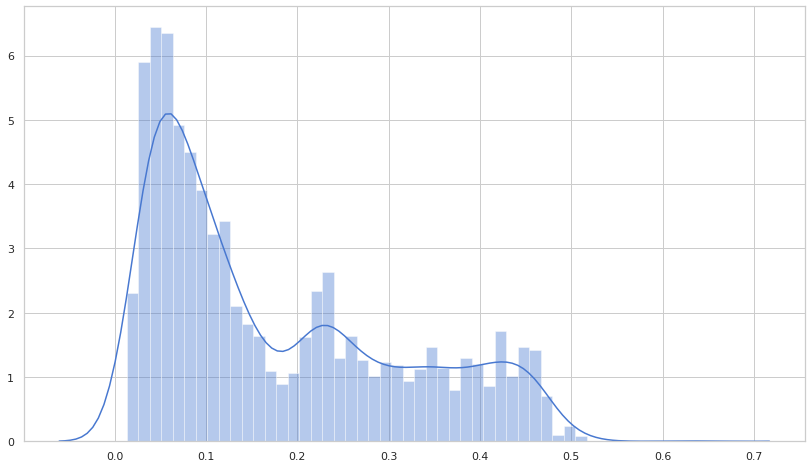

In [15]:
sns.distplot(train_mae_loss,bins=50,kde=True) 

In [16]:
threshold=0.65
X_test_pred=model.predict(X_test)
test_mae_loss=np.mean(np.abs(X_test_pred-X_test) ,axis=1)

In [17]:
test_score_df=pd.DataFrame(test[timesteps:])
test_score_df['loss']=test_mae_loss
test_score_df['threshold']=threshold 
test_score_df['anomaly']=test_score_df.loss > test_score_df.threshold
test_score_df['close']=test[time_steps:].close
test_score_df.tail()


,date,close,loss,threshold,anomaly
8187,2018-06-25,4.493228,0.652183,0.65,True
8188,2018-06-26,4.507583,0.705046,0.65,True
8189,2018-06-27,4.451431,0.710094,0.65,True
8190,2018-06-28,4.491406,0.740896,0.65,True
8191,2018-06-29,4.496343,0.722983,0.65,True


In [18]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=test[timesteps:].date,y=test_score_df.loss,mode='lines',name='Test loss'))
fig.add_trace(go.Scatter(x=test[timesteps:].date,y=test_score_df.threshold,mode='lines',name='Threshold'))
fig.update_layout(showlegend=True)
fig.show()

In [19]:
anomalies=test_score_df[test_score_df.anomaly==True]
anomalies.head()

,date,close,loss,threshold,anomaly
7474,2015-08-25,2.457439,0.662046,0.65,True
7475,2015-08-26,2.632149,0.717697,0.65,True
8090,2018-02-05,4.329949,0.669954,0.65,True
8091,2018-02-06,4.440671,0.859668,0.65,True
8092,2018-02-07,4.408365,0.835642,0.65,True


In [20]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=test[timesteps:].date,y=scaler.inverse_transform(test[timesteps:].close),mode='lines',name='Close price'))
fig.add_trace(go.Scatter(x=anomalies.date,y=scaler.inverse_transform(anomalies.close),mode='markers',name='An'))
fig.update_layout(showlegend=True)
fig.show()